# Layer Cake Example

#### In this example we will see basic functionality of the `KirchMig.jl` package, including standard and least-squares Kirchhoff migration demigration.

### 0. Load modules

In [1]:
#addprocs(Sys.CPU_CORES)
import PyPlot; const plt = PyPlot
import KirchMig; const km = KirchMig;

### 1. Create reflection data

First step is to create a reflection data, which we will use to demonstrate Kirchhoff demigration. Later, we will use this data for migration.

In [2]:
dz, dx = 15, 15
x = 0:dx:1000; nx = length(x)
z = 0:dz:1000; nz = length(z)

rho = 1000ones(nz, nx)
rho[div(330,dx):end,:] += 1000
rho[div(670,dz):end,:] -= 500

vel = similar(rho); vel .= 2000;

blk = rho.*vel.^2;

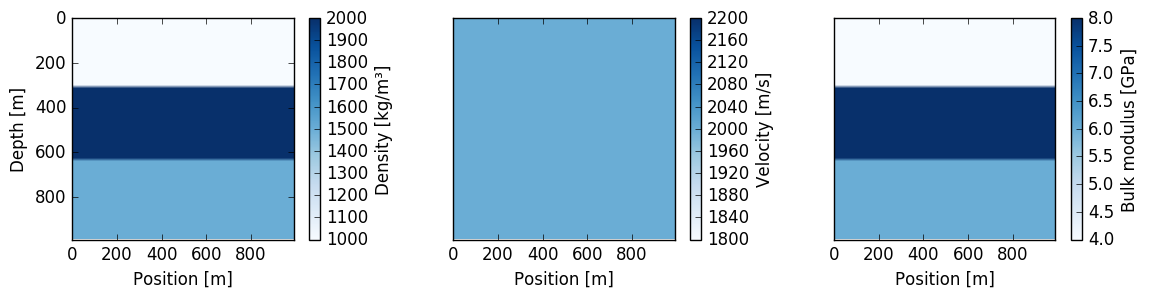

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))

# Density
cax = ax[1][:imshow](rho, extent=[x[1], x[end], z[end], z[1]], aspect="equal", cmap="Blues")
ax[1][:set](xlabel="Position [m]", ylabel="Depth [m]")
cbar = fig[:colorbar](cax, ax=ax[1])
cbar[:ax][:set](ylabel="Density [kg/m³]")

# Velocity
cax = ax[2][:imshow](vel, extent=[x[1], x[end], z[end], z[1]], aspect="equal", cmap="Blues")
ax[2][:set](xlabel="Position [m]", yticks=[])
cbar = fig[:colorbar](cax, ax=ax[2])
cbar[:ax][:set](ylabel="Velocity [m/s]");

cax = ax[3][:imshow](1e-9blk, extent=[x[1], x[end], z[end], z[1]], aspect="equal", cmap="Blues")
ax[3][:set](xlabel="Position [m]", yticks=[])
cbar = fig[:colorbar](cax, ax=ax[3])
cbar[:ax][:set](ylabel="Bulk modulus [GPa]");
fig[:tight_layout]()

In [4]:
refl = [zeros(nx)'
    (blk[2:end,:] - blk[1:end-1,:])./(blk[2:end,:]+blk[1:end-1,:])];

ricker(to, f) = (1 - 2pi^2 * f^2 * to.^2) .* exp.(-pi^2 * f^2 * to.^2)
rick = ricker(z-z[div(nz-1,2)+1], 0.01); 

mod_bl = hcat( (conv(refl[:,ix], rick)[div(nz-1,2)+1:div(3nz-1,2)] for ix in 1:nx)... );

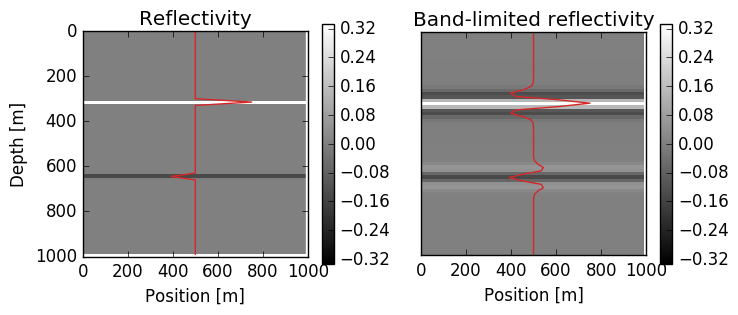

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
vmin, vmax = maximum(abs.(refl))*[-1,1]
cax = ax[1][:imshow](refl, extent=[x[1], x[end], z[end], z[1]],
    vmin=-maximum(abs.(refl)), vmax=maximum(abs.(refl)), cmap="gray", interpolation="none")
ax[1][:set](xlabel="Position [m]", ylabel="Depth [m]", title="Reflectivity")
cbar = fig[:colorbar](cax, ax=ax[1])
ax[1][:plot](250refl[:,50]/vmax+500, z, color="#d62728")

vmin, vmax = maximum(abs.(mod_bl))*[-1,1]
cax = ax[2][:imshow](mod_bl, extent=[x[1], x[end], z[end], z[1]], vmin=vmin, vmax=vmax, cmap="gray",
    interpolation="none")
ax[2][:set](xlabel="Position [m]", title="Band-limited reflectivity", yticks=[])
cbar = fig[:colorbar](cax, ax=ax[2])
ax[2][:plot](250mod_bl[:,50]/vmax+500, z, color="#d62728");

### 2. Create traveltime tables

The Kirchhoff modeling (or, more accurately, demigration) and migration operators require source/receiver traveltime tables. That is, they require one to know traveltimes from each source/receiver to each model point. In the case of a constant velocity, this can be easily calculated with the this formula:

$$ trav(z, x; z_{S/R}, x_{S/R}) = \frac{\sqrt{(z-z_{S/R})^2 + (x-x_{S/R})^2)}}{v}$$

where $(z, x)$ are the coordinates of subsurface point, $(z_{S/R}, x_{S/R})$ are the coordinates of the source/receiver and $v$ is the velocity.

This calculated is implemented in `eikonal_const_vel`, whose first argument takes an `AbstractMatrix` whose first column contains $z$ coordinates of all sources (or receivers), $z_{S/R,1}, \ldots z_{S/R,n}$; the second column contains $x$ coordinates of these same sources $x_{S/R,1}, \ldots x_{S/R,n}$, and so on until all spatial dimensions are accounted for. Its second and third arguments take `AbstractVector`s representing, respectively, $z$ and $x$ subsurface locations. In 3D, the fourth argument are the subsurface $y$ locations. The last argument is the velocity.

For now, we will use coinciding sources/receivers, so we will only calculate one traveltime table. When sources and receivers are in different positions, two separate traveltime tables must be computed.

In [6]:
ns = 50

src_z = zeros(ns)
src_x = 0:20:(ns-1)*20

trav = km.eikonal_const_vel([src_z src_x], z, x, vel[1]);

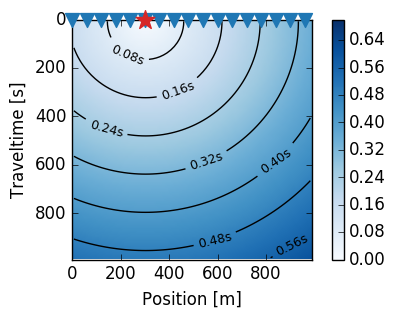

In [7]:
fig, ax = plt.subplots(figsize=(5,3))
cax = ax[:imshow](trav[:,:,div(ns,3)], extent=[x[1], x[end], z[end], z[1]], vmin=0, vmax=maximum(trav),
    aspect="equal", cmap="Blues")
ax[:set](xlabel="Position [m]", ylabel="Depth [m]")
cbar = fig[:colorbar](cax, ax=ax)
ax[:scatter](src_x[1:3:end], src_z[1:3:end], color="#1f77b4", marker="v", s=100, clip_on=false, zorder=100)
ax[:scatter](src_x[div(ns,3)], src_z[div(ns,3)], color="#d62728", marker="*", s=200, clip_on=false, zorder=100)
con = ax[:contour](trav[:,:,div(ns,3)], extent=[x[1], x[end], z[end], z[1]], origin="upper", colors="k")
plt.clabel(con, fontsize=9, inline=1, fmt="%1.2fs");
ax[:set](ylabel="Traveltime [s]", xlim=(x[1], x[end]), ylim=(z[end], z[1]));

### 3. Kirchhoff demigration (modeling)

`KirchMig` provides a simple to use interface around modeling and migration: `KirchMap`. The forward map performs modeling, and the adjoint performs migration. In simple terms, if `m` is the reflectivity model and `d` is the reflection response data (both vector format), modeling is performed with

$$ Lm = d $$

and migration is performed with

$$ m_\text{mig} = L^\dagger d.$$

where $\dagger$ represents the adjoint. Both operations rely on two key pieces of information. The first is the time axis of the data. We will create a standard time axis of at most `2s` sampling every `4ms`.

The second key piece of information are the traveltime tables — the time it takes for waves to propagate from the subsurface locations to the sources/receivers — which we have computed above.

In [8]:
t = 0:0.008:1; nt = length(t); reload("KirchMig")
L = KirchMig.KirchMap(t, trav)

KirchMig.KirchMap{Float64}(KirchMig.#40, KirchMig.#41, 315000, 4489; ismutating=false, issymmetric=false, ishermitian=false, isposdef=false, parallel_threaded_serial=parallel)

Once the operator is defined, Kirchhoff modeling is carried out like a simple matrix-vector multiplication.

In [9]:
@time d = L*mod_bl[:];

  5.659630 seconds (65.81 M allocations: 1.920 GiB, 4.89% gc time)


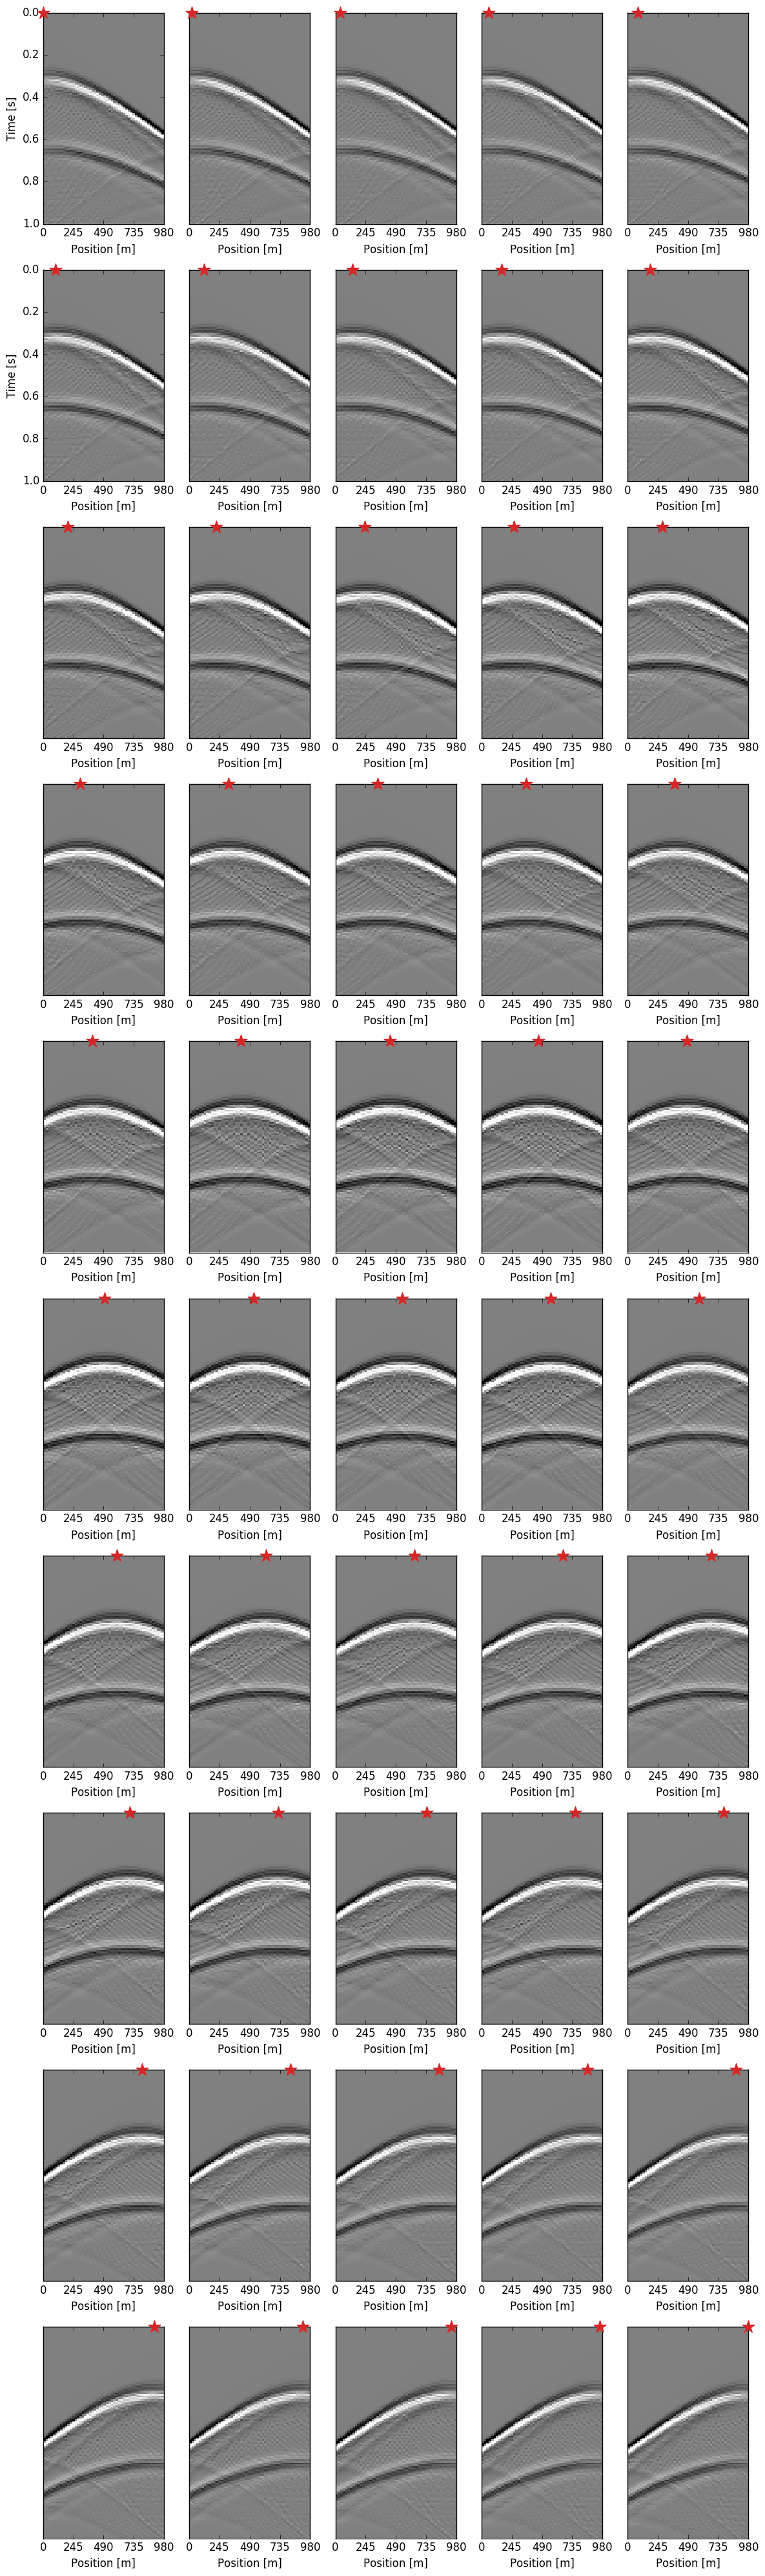

In [10]:
data = reshape(d, ns, ns, nt)

rows = 10
fig, ax = plt.subplots(rows, div(ns, rows), figsize=(12,4*rows))
idx = reshape(1:rows*div(ns, rows), div(ns, rows), rows)'
for (i, axi) in enumerate(ax)
    csg = data[:,idx[i],:]'
    cax = axi[:imshow](csg, extent=[src_x[1], src_x[end], t[end], t[1]],
        vmin=-0.5maximum(abs.(csg)), vmax=0.5maximum(abs.(csg)), aspect="auto", cmap="gray", interpolation="none")
    axi[:scatter](src_x[idx[i]], t[1], color="#d62728", marker="*", s=200, clip_on=false, zorder=100)
    axi[:set](xlim=(src_x[1],src_x[end]), ylim=(t[end], t[1]), xlabel="Position [m]",
        xticks = linspace(minimum(src_x), maximum(src_x), 5))
    if idx[i] != 1 && idx[i] != div(ns,rows)+1
        axi[:set](yticks=[])
    else
        axi[:set](ylabel="Time [s]")
    end
end
fig[:tight_layout]()

### 4. Kirchhoff migration

Migration is simply the other side of the coin: it can be calculated by multiplication of the transpose $L$ by the data.

In [11]:
@time m_mig = L'd;

  1.308523 seconds (483.25 k allocations: 970.091 MiB, 6.87% gc time)


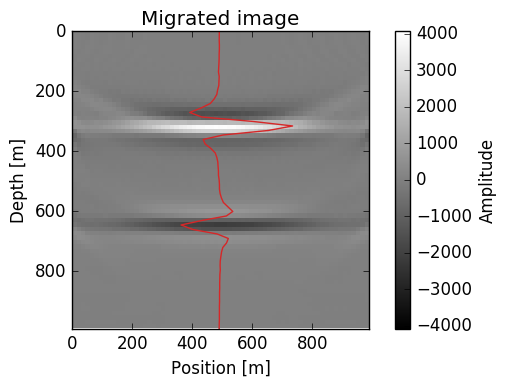

In [12]:
xran = src_x[end]-src_x[1]
mod_mig = reshape(m_mig, nz, nx)
vmin, vmax = maximum(abs.(mod_mig))*[-1,1]
fig, ax = plt.subplots(figsize=(6,4))
cax = ax[:imshow](mod_mig, extent=[x[1], x[end], z[end], z[1]],
    vmin=vmin, vmax=vmax, aspect="equal", cmap="gray", interpolation="none")
cbar = fig[:colorbar](cax, ax=ax)
cbar[:ax][:set](ylabel="Amplitude");
ax[:plot](xran*mod_mig[:,div(end,2)]/(4vmax) + xran/2, z, color="#d62728");
ax[:set](xlim=(x[1], x[end]), ylim=(z[end], z[1]), xlabel="Position [m]", ylabel="Depth [m]",
    title="Migrated image")
fig[:tight_layout]()

### 5. Least-squares migration

If we apply the Kirchhoff migration operator to the forward equation, we obtain the following relationship

$$ L^\dagger Lm = L^\dagger d $$

where the right-hand side is equivalent to $m_\text{mig}$. Clearly, unless $L^\dagger L$ happens to be the identity, $m_\text{mig} \neq m$.

In least-squares migration, we attempt to invert $L^\dagger L$ and find the true inverse. Computing inverses directly, however, is seldom the best idea. First, the size of matrix $L^\dagger L$ is usually very large (in this case it is a meager 4489×4489). Second, the problem may be ill-posed, meaning that $L^\dagger L$ may lack an inverse. Instead we favor conditioned iterative methods of regularized problems, such as conjugate gradients. `KirchMig.jl` provides a very simple CG method, which here we will not precondition. We will see regularization in another example.


In [13]:
@time m_lsm, _, hist_r = KirchMig.cg(L'L, m_mig, maxiter=20, log=true);

 95.156377 seconds (1.37 G allocations: 59.203 GiB, 7.67% gc time)


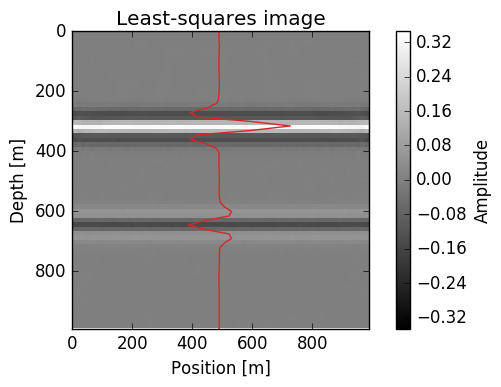

In [14]:
mod_lsm = reshape(m_lsm, nz, nx)
vmin, vmax = maximum(abs.(mod_lsm))*[-1,1]
fig, ax = plt.subplots(figsize=(6,4))
cax = ax[:imshow](mod_lsm, extent=[x[1], x[end], z[end], z[1]],
    vmin=vmin, vmax=vmax, aspect="equal", cmap="gray", interpolation="none")
cbar = fig[:colorbar](cax, ax=ax)
cbar[:ax][:set](ylabel="Amplitude");
ax[:plot](xran*mod_lsm[:,div(end,2)]/(4vmax) + xran/2, z, color="#d62728");
ax[:set](xlim=(x[1], x[end]), ylim=(z[end], z[1]), xlabel="Position [m]", ylabel="Depth [m]",
    title="Least-squares image")
fig[:tight_layout]()

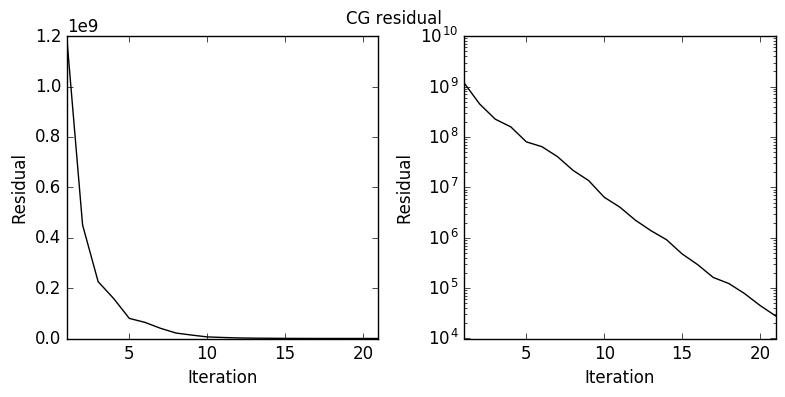

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[1][:plot](1:length(hist_r), hist_r, "k")
ax[1][:set](xlim=(1, length(hist_r)), xlabel="Iteration", ylabel="Residual");
ax[2][:semilogy](1:length(hist_r), hist_r, "k")
ax[2][:set](xlim=(1, length(hist_r)), xlabel="Iteration", ylabel="Residual");
fig[:suptitle]("CG residual")
fig[:tight_layout]()

The image looks good, as well as the data-space errors (residuals). We can also visualize the (normalized) model-space errors:

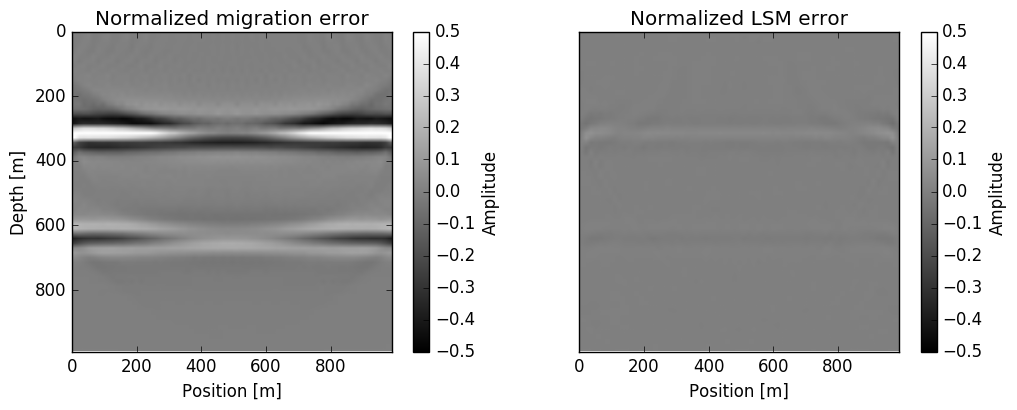

In [16]:
err_mig = mod_bl/maximum(mod_bl) - mod_mig/maximum(mod_mig)
err_lsm = mod_bl/maximum(mod_bl) - mod_lsm/maximum(mod_lsm)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
pclip=.5
cax = ax[1][:imshow](err_mig, extent=[x[1], x[end], z[end], z[1]],
    vmin=-pclip, vmax=pclip, aspect="equal", cmap="gray")
ax[1][:set](xlabel="Position [m]", ylabel="Depth [m]", title="Normalized migration error")
cbar = fig[:colorbar](cax, ax=ax[1])
cbar[:ax][:set](ylabel="Amplitude");

vmin, vmax = pclip*maximum(abs.(mod_lsm))*[-1,1]
cax = ax[2][:imshow](err_lsm, extent=[x[1], x[end], z[end], z[1]],
    vmin=-pclip, vmax=pclip, aspect="equal", cmap="gray")
ax[2][:set](xlabel="Position [m]",title="Normalized LSM error", yticks=[]);
cbar = fig[:colorbar](cax, ax=ax[2])
cbar[:ax][:set](ylabel="Amplitude");

Clearly LSM performs *much* better. Everywhere in the model has improved. We can also observe that standard migration has a systematic error which LSM lacks. Let us now take a vertical trace where standard migration has done the its best and worst, and show how the vertical resolution has also improved.

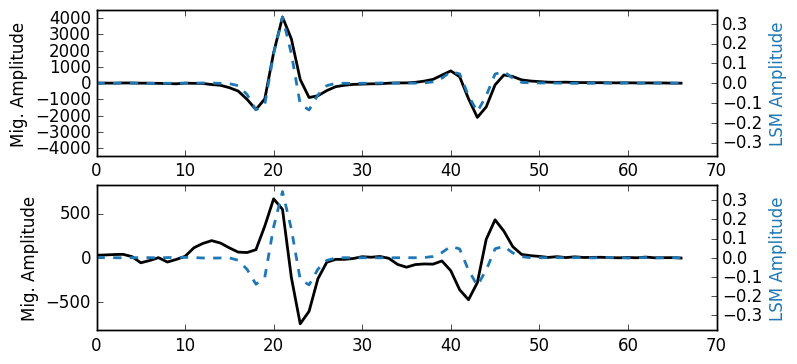

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(8,4))
ax[1][:plot](mod_mig[:,div(end,2)], "k", linewidth=2)
ax[1][:set](ylabel="Mig. Amplitude", ylim=[-1.1,1.1]*maximum(abs.(mod_mig[:,div(end,2)])))
ax2 = ax[1][:twinx]()
ax2[:plot](mod_lsm[:,div(end,2)], "--", color="#1f77b4", linewidth=2)
ax2[:set](ylim=[-1.1,1.1]*maximum(abs.(mod_lsm[:,div(end,2)])))
ax2[:set_ylabel]("LSM Amplitude", color="#1f77b4")

ax[2][:plot](mod_mig[:,1], "k", linewidth=2)
ax[2][:set](ylabel="Mig. Amplitude", ylim=[-1.1,1.1]*maximum(abs.(mod_mig[:,1])))
ax2 = ax[2][:twinx]()
ax2[:plot](mod_lsm[:,1], "--", color="#1f77b4", linewidth=2)
ax2[:set](ylim=[-1.1,1.1]*maximum(abs.(mod_lsm[:,1])))
ax2[:set_ylabel]("LSM Amplitude", color="#1f77b4");

Even where migration does a decent job, there is still an improvement in resolution and phase. Where standard migration is very poor, LSM has a very similar performance as when it does its best.